<a href="https://colab.research.google.com/github/LordRelentless/AI3DModelGenerator/blob/main/Copy_of_EMF_Coil_Thermo_Sensor_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tier 1: Fast Sim Stage 1

Feature vector length per plane: 9
T_fluid reconstruction R^2: 0.318
v reconstruction R^2: 0.689
damage reconstruction R^2: 0.564


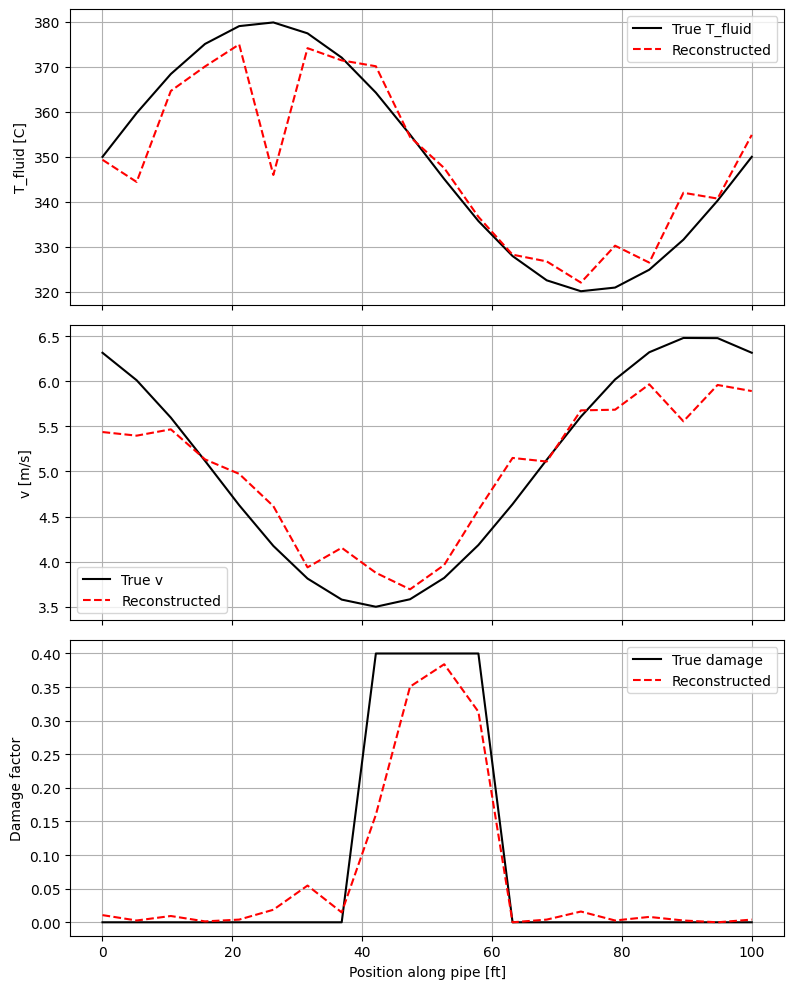

In [ ]:
# Tier 1: Conceptual EM-coil sensing simulation for a 100 ft pipe with 20 planes

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

np.random.seed(42)

# -----------------------------
# 1. Define pipe and "true" fields
# -----------------------------
n_planes = 20
z = np.linspace(0, 100, n_planes)  # position along pipe [ft]

# True underlying fields (you can tweak these shapes)
T_fluid_true = 350 + 30 * np.sin(2 * np.pi * z / 100)          # fluid temperature [C]
T_wall_true  = T_fluid_true + 10 * np.exp(-z / 50)             # wall slightly hotter near inlet
v_true       = 5 + 1.5 * np.cos(2 * np.pi * z / 100 + 0.5)     # flow rate [m/s]
P_true       = 100 + 5 * (1 - z / 100)                         # pressure [bar], gently dropping
D_true       = np.zeros_like(z)                                # damage factor [0..1]
D_true[8:12] = 0.4                                             # localized overstressed region

# -----------------------------
# 2. Define simple EM feature model
# -----------------------------
# Frequencies for driven response (conceptual)
freqs = np.array([500, 2000, 8000])  # Hz

def generate_em_features(Tw, Tf, v, P, D):
    """
    Generate conceptual EM features for one plane:
    - Coarse: impedance real/imag at 3 frequencies
    - Fine: noise RMS, burstiness, spectral slope
    """
    # Temperature-dependent "conductivity" proxy (lower with higher Tw)
    sigma_wall = 1.0 / (1.0 + 0.003 * (Tw - 300))  # arbitrary scaling

    # Damage increases effective resistivity and disturbs permeability
    sigma_eff = sigma_wall * (1.0 - 0.5 * D)
    mu_eff    = 1.0 + 0.5 * np.exp(-((Tw - 400) / 80)**2) * (1 + D)

    # Coarse impedance model: Z = R + jX at each frequency
    # R ~ 1/sigma_eff, X ~ mu_eff * freq
    R = (1.0 / sigma_eff) * (1 + 0.1 * np.random.randn(len(freqs)))
    X = (mu_eff * freqs / freqs.mean()) * (1 + 0.1 * np.random.randn(len(freqs)))

    # Fine-grain noise features
    # Noise RMS grows with v, D, and Tw
    noise_rms = 0.1 + 0.02 * (v - v.mean()) + 0.03 * D + 0.0005 * (Tw - 350)
    noise_rms += 0.01 * np.random.randn()

    # Burstiness: more bursts with higher v and D
    burstiness = 0.2 + 0.05 * (v - v.mean()) + 0.1 * D + 0.01 * np.random.randn()

    # Spectral slope: slightly steeper with more damage and higher Tw
    spectral_slope = -1.5 + 0.002 * (Tw - 350) - 0.3 * D + 0.05 * np.random.randn()

    # Pack features
    features = np.concatenate([R, X, [noise_rms, burstiness, spectral_slope]])
    return features

# Generate EM features for all planes
X_features = np.array([
    generate_em_features(Tw, Tf, v, P, D)
    for Tw, Tf, v, P, D in zip(T_wall_true, T_fluid_true, v_true, P_true, D_true)
])

print("Feature vector length per plane:", X_features.shape[1])

# -----------------------------
# 3. Try to reconstruct T_fluid, v, and damage from EM features
# -----------------------------
targets = {
    "T_fluid": T_fluid_true,
    "v": v_true,
    "damage": D_true
}

models = {}
preds = {}

for name, y in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y, test_size=0.3, random_state=42
    )
    model = RandomForestRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} reconstruction R^2: {r2:.3f}")
    models[name] = model
    preds[name] = model.predict(X_features)

# -----------------------------
# 4. Plot true vs reconstructed profiles
# -----------------------------
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axes[0].plot(z, T_fluid_true, 'k-', label='True T_fluid')
axes[0].plot(z, preds["T_fluid"], 'r--', label='Reconstructed')
axes[0].set_ylabel("T_fluid [C]")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(z, v_true, 'k-', label='True v')
axes[1].plot(z, preds["v"], 'r--', label='Reconstructed')
axes[1].set_ylabel("v [m/s]")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(z, D_true, 'k-', label='True damage')
axes[2].plot(z, preds["damage"], 'r--', label='Reconstructed')
axes[2].set_ylabel("Damage factor")
axes[2].set_xlabel("Position along pipe [ft]")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

Tier 1: Refining EM structure

---



Feature vector length per plane (refined): 10
T_fluid reconstruction R^2 (refined): 0.804
v reconstruction R^2 (refined): 0.916
damage reconstruction R^2 (refined): 0.986


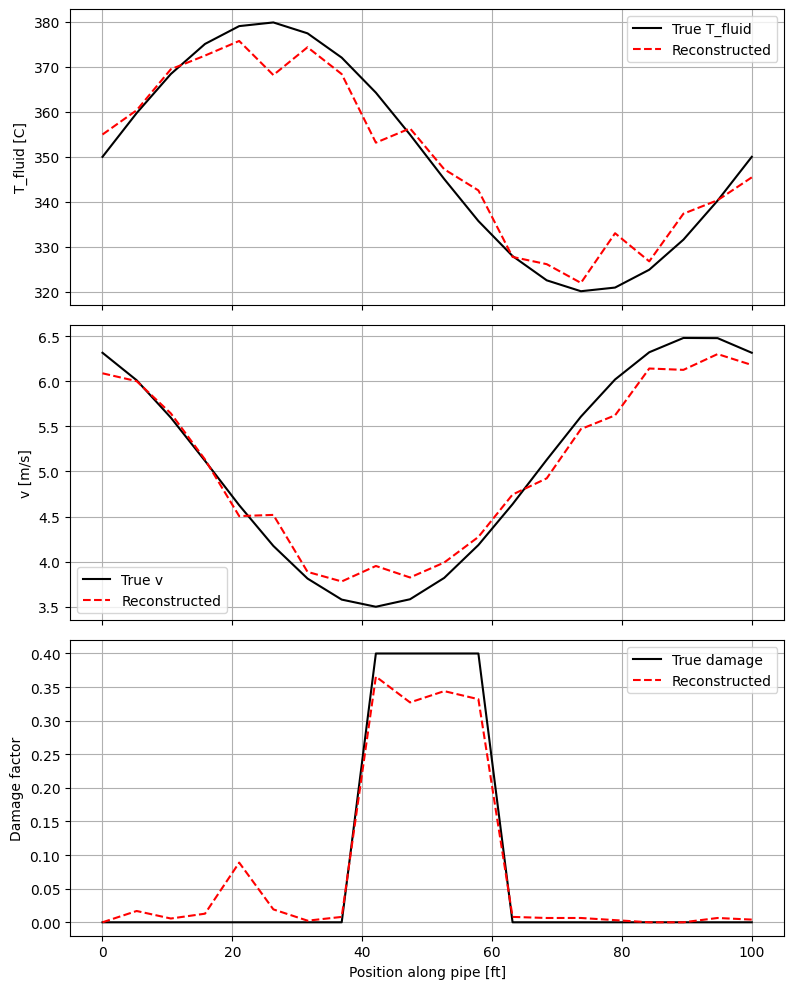

In [ ]:
# -----------------------------
# 2. Refined EM feature model
# -----------------------------
freqs = np.array([300, 1500, 6000])  # Hz

def generate_em_features_refined(Tw, Tf, v, P, D):
    """
    Refined conceptual EM features:
    - Stronger, more distinct dependence on Tw, Tf, v, D
    - Coarse: impedance real/imag at 3 frequencies
    - Fine: noise RMS, burstiness, spectral slope, plus one extra "spike rate"
    """
    # Temperature-dependent wall conductivity (stronger Tw effect)
    sigma_wall = 1.0 / (1.0 + 0.006 * (Tw - 300))  # more sensitive to Tw

    # Fluid temperature influences near-wall behavior (e.g., via heat transfer regime)
    sigma_fluid = 1.0 / (1.0 + 0.004 * (Tf - 300))

    # Damage increases effective resistivity and disturbs permeability more strongly
    sigma_eff = sigma_wall * (1.0 - 0.7 * D) + 0.1 * sigma_fluid
    mu_eff    = 1.0 + 0.8 * np.exp(-((Tw - 400) / 70)**2) * (1 + 1.5 * D)

    # Coarse impedance model: Z = R + jX at each frequency
    R = (1.0 / sigma_eff) * (1 + 0.05 * np.random.randn(len(freqs)))
    X = (mu_eff * freqs / freqs.mean()) * (1 + 0.05 * np.random.randn(len(freqs)))

    # Fine-grain noise features
    # Noise RMS grows with v, D, and Tw, but now also with Tf
    noise_rms = (
        0.1
        + 0.03 * (v - v_true.mean())
        + 0.05 * D
        + 0.0008 * (Tw - 350)
        + 0.0005 * (Tf - 350)
        + 0.01 * np.random.randn()
    )

    # Burstiness: more bursts with higher v and D, slightly with Tf
    burstiness = (
        0.2
        + 0.06 * (v - v_true.mean())
        + 0.12 * D
        + 0.0005 * (Tf - 350)
        + 0.01 * np.random.randn()
    )

    # Spectral slope: steeper with more damage and higher Tw
    spectral_slope = (
        -1.5
        + 0.003 * (Tw - 350)
        - 0.5 * D
        + 0.05 * np.random.randn()
    )

    # Extra fine-grain feature: "spike rate" (e.g., micro-discharge events)
    spike_rate = (
        5
        + 0.8 * D
        + 0.4 * (v - v_true.mean())
        + 0.002 * (Tw - 350)
        + 0.0015 * (Tf - 350)
        + np.random.randn()
    )

    features = np.concatenate([R, X, [noise_rms, burstiness, spectral_slope, spike_rate]])
    return features

# Regenerate EM features with refined model
X_features = np.array([
    generate_em_features_refined(Tw, Tf, v, P, D)
    for Tw, Tf, v, P, D in zip(T_wall_true, T_fluid_true, v_true, P_true, D_true)
])

print("Feature vector length per plane (refined):", X_features.shape[1])

# -----------------------------
# 3. Retrain regressors
# -----------------------------
targets = {
    "T_fluid": T_fluid_true,
    "v": v_true,
    "damage": D_true
}

models = {}
preds = {}

for name, y in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y, test_size=0.3, random_state=42
    )
    model = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=None)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} reconstruction R^2 (refined): {r2:.3f}")
    models[name] = model
    preds[name] = model.predict(X_features)

# -----------------------------
# 4. Plot true vs reconstructed profiles
# -----------------------------
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axes[0].plot(z, T_fluid_true, 'k-', label='True T_fluid')
axes[0].plot(z, preds["T_fluid"], 'r--', label='Reconstructed')
axes[0].set_ylabel("T_fluid [C]")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(z, v_true, 'k-', label='True v')
axes[1].plot(z, preds["v"], 'r--', label='Reconstructed')
axes[1].set_ylabel("v [m/s]")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(z, D_true, 'k-', label='True damage')
axes[2].plot(z, preds["damage"], 'r--', label='Reconstructed')
axes[2].set_ylabel("Damage factor")
axes[2].set_xlabel("Position along pipe [ft]")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

Tier 1: further fine tuning.

Feature vector length per plane-time: 10
Total samples: 1600
T_fluid R^2 (train early time, test late time): 0.816
v R^2 (train early time, test late time): 0.921
damage R^2 (train early time, test late time): 0.710


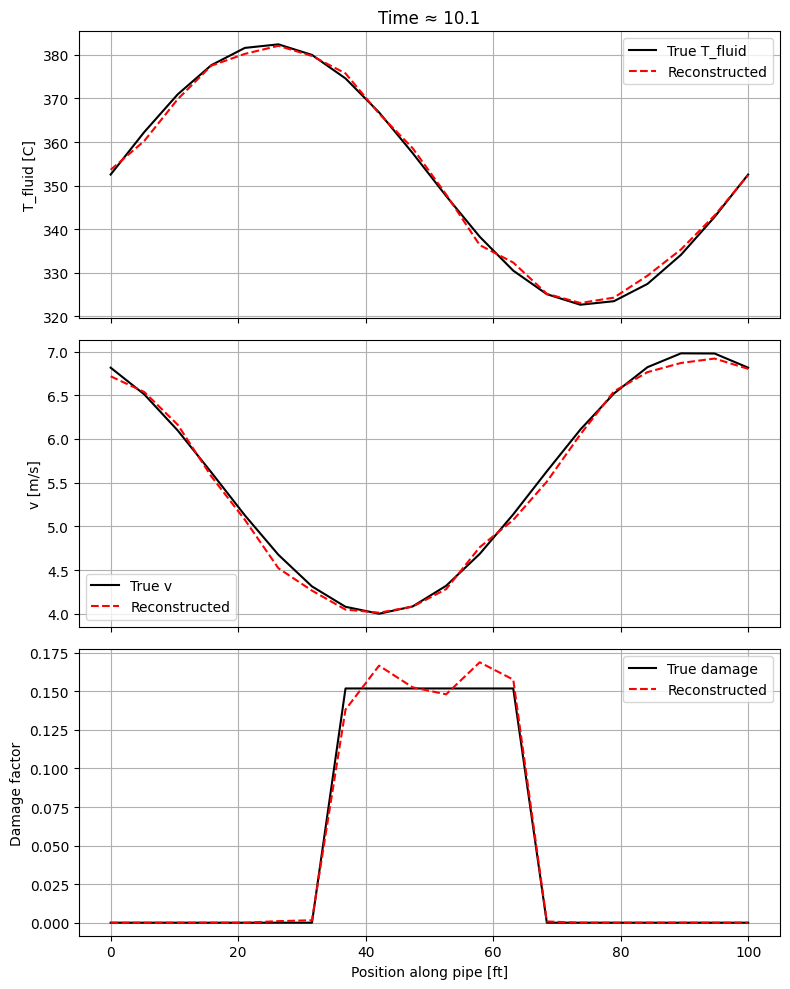

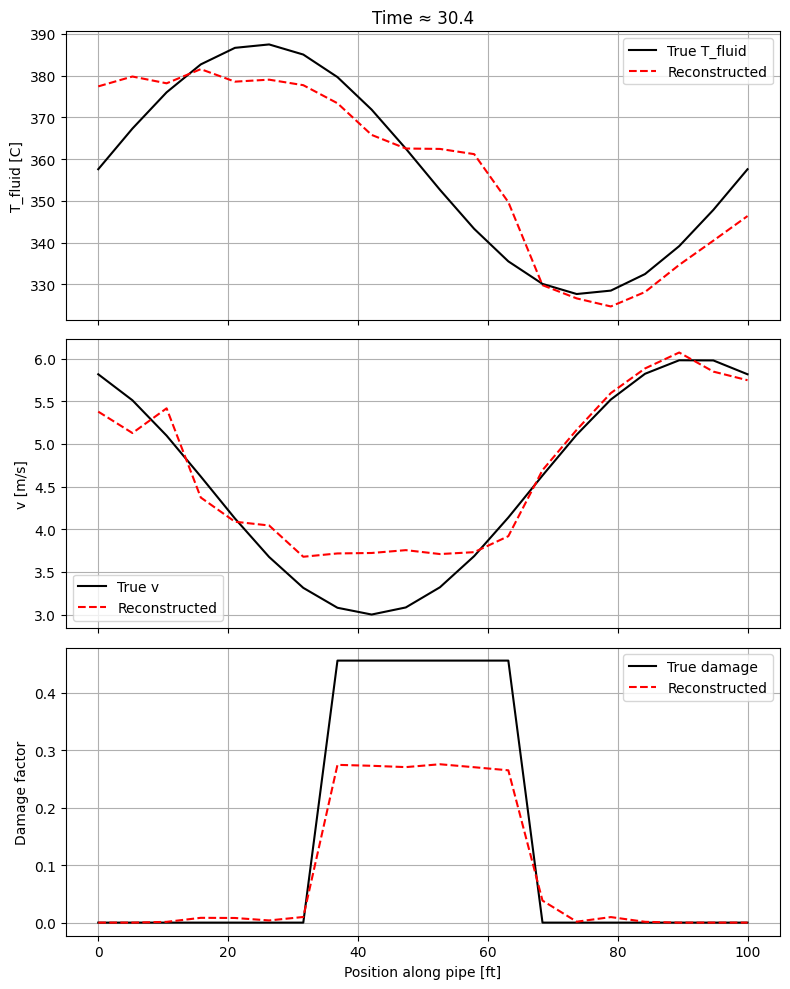

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

np.random.seed(123)

# -----------------------------
# 1. Space–time grid and "true" fields
# -----------------------------
n_planes = 20
n_time   = 80

z = np.linspace(0, 100, n_planes)          # position [ft]
t = np.linspace(0, 40, n_time)             # time [arbitrary units]

Z, Tm = np.meshgrid(z, t, indexing='ij')   # Z: (planes, time), Tm: (planes, time)

# Base spatial patterns
T_fluid_base = 350 + 30 * np.sin(2 * np.pi * Z / 100)
v_base       = 5 + 1.5 * np.cos(2 * np.pi * Z / 100 + 0.5)
P_base       = 100 + 5 * (1 - Z / 100)

# Time evolution:
# - Fluid temperature ramps up slightly
# - Flow rate oscillates slowly
# - Damage grows in a localized region over time
T_fluid_true = T_fluid_base + 10 * (Tm / Tm.max())  # slow global heating
v_true       = v_base + 0.5 * np.sin(2 * np.pi * Tm / Tm.max())
P_true       = P_base - 2 * (Tm / Tm.max())

D_true = np.zeros_like(Z)
damage_region = (Z > 35) & (Z < 65)
D_true[damage_region] = 0.6 * (Tm[damage_region] / Tm.max())  # damage grows over time in mid-section

# Wall temperature slightly above fluid, plus some spatial decay
T_wall_true = T_fluid_true + 8 * np.exp(-Z / 60)

# -----------------------------
# 2. Slightly more "physical" EM feature model
# -----------------------------
freqs = np.array([300, 1500, 6000])  # Hz

def steel_resistivity(Tw):
    # Simple linear-ish increase with temperature (arbitrary units)
    return 1.0 + 0.004 * (Tw - 300)

def steel_mu(Tw):
    # Bell-shaped permeability vs temperature (peak around ~400 C)
    return 1.0 + 1.2 * np.exp(-((Tw - 400) / 80)**2)

def generate_em_features_tier13(Tw, Tf, v, P, D):
    """
    Tier 1.3 EM features:
    - Coarse: impedance real/imag at 3 frequencies
    - Fine: noise RMS, burstiness, spectral slope, spike rate
    """
    rho_wall = steel_resistivity(Tw)          # resistivity proxy
    mu_wall  = steel_mu(Tw)                   # permeability proxy

    # Damage increases effective resistivity and perturbs mu
    rho_eff = rho_wall * (1.0 + 1.0 * D)
    mu_eff  = mu_wall * (1.0 + 0.8 * D)

    # Fluid temperature influences near-wall behavior (e.g., heat transfer regime)
    rho_fluid = 1.0 + 0.003 * (Tf - 300)

    # Effective parameters (simple mixing)
    rho_comb = rho_eff + 0.2 * rho_fluid
    mu_comb  = mu_eff

    # Coarse impedance: R ~ rho_comb, X ~ mu_comb * f
    R = rho_comb * (1 + 0.05 * np.random.randn(len(freqs)))
    X = (mu_comb * freqs / freqs.mean()) * (1 + 0.05 * np.random.randn(len(freqs)))

    # Fine-grain features
    # Noise RMS grows with v, D, Tw, Tf
    noise_rms = (
        0.1
        + 0.03 * (v - 5)
        + 0.05 * D
        + 0.0007 * (Tw - 350)
        + 0.0005 * (Tf - 350)
        + 0.01 * np.random.randn()
    )

    # Burstiness: more with v, D, and boiling-like conditions (Tf high)
    burstiness = (
        0.2
        + 0.06 * (v - 5)
        + 0.12 * D
        + 0.0008 * (Tf - 350)
        + 0.01 * np.random.randn()
    )

    # Spectral slope: steeper with more damage and higher Tw
    spectral_slope = (
        -1.5
        + 0.003 * (Tw - 350)
        - 0.5 * D
        + 0.05 * np.random.randn()
    )

    # Spike rate: micro-discharge / transient events
    spike_rate = (
        5
        + 0.9 * D
        + 0.4 * (v - 5)
        + 0.002 * (Tw - 350)
        + 0.0015 * (Tf - 350)
        + np.random.randn()
    )

    features = np.concatenate([R, X, [noise_rms, burstiness, spectral_slope, spike_rate]])
    return features

# Generate features for all planes and times
X_list = []
y_Tf_list = []
y_v_list = []
y_D_list = []
pos_list = []
time_list = []

for i in range(n_planes):
    for j in range(n_time):
        Tw = T_wall_true[i, j]
        Tf = T_fluid_true[i, j]
        v  = v_true[i, j]
        P  = P_true[i, j]
        D  = D_true[i, j]

        feats = generate_em_features_tier13(Tw, Tf, v, P, D)
        X_list.append(feats)
        y_Tf_list.append(Tf)
        y_v_list.append(v)
        y_D_list.append(D)
        pos_list.append(z[i])
        time_list.append(t[j])

X_features = np.array(X_list)
y_Tf = np.array(y_Tf_list)
y_v  = np.array(y_v_list)
y_D  = np.array(y_D_list)
pos  = np.array(pos_list)
time = np.array(time_list)

print("Feature vector length per plane-time:", X_features.shape[1])
print("Total samples:", X_features.shape[0])

# -----------------------------
# 3. Train on early time, test on later time
# -----------------------------
# Train on first 50% of time, test on last 50%
time_threshold = np.median(time)

train_mask = time <= time_threshold
test_mask  = time > time_threshold

def train_and_eval(name, y):
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=500, random_state=42)
    model.fit(X_features[train_mask], y[train_mask])
    y_pred = model.predict(X_features[test_mask])
    r2 = r2_score(y[test_mask], y_pred)
    print(f"{name} R^2 (train early time, test late time): {r2:.3f}")
    # Also predict over all for plotting
    y_all = model.predict(X_features)
    return model, y_all

model_Tf, Tf_pred_all = train_and_eval("T_fluid", y_Tf)
model_v,  v_pred_all  = train_and_eval("v",       y_v)
model_D,  D_pred_all  = train_and_eval("damage",  y_D)

# -----------------------------
# 4. Visualize one early and one late time slice
# -----------------------------
def plot_slice(time_value, Tf_true, Tf_pred, v_true, v_pred, D_true, D_pred):
    # pick closest time index
    idx_t = np.argmin(np.abs(t - time_value))
    mask = (np.abs(time - t[idx_t]) < 1e-6)

    z_slice = pos[mask]
    Tf_t    = Tf_true.reshape(n_planes, n_time)[:, idx_t]
    Tf_p    = Tf_pred.reshape(n_planes, n_time)[:, idx_t]
    v_t     = v_true.reshape(n_planes, n_time)[:, idx_t]
    v_p     = v_pred.reshape(n_planes, n_time)[:, idx_t]
    D_t     = D_true.reshape(n_planes, n_time)[:, idx_t]
    D_p     = D_pred.reshape(n_planes, n_time)[:, idx_t]

    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    axes[0].plot(z, Tf_t, 'k-', label='True T_fluid')
    axes[0].plot(z, Tf_p, 'r--', label='Reconstructed')
    axes[0].set_ylabel("T_fluid [C]")
    axes[0].set_title(f"Time ≈ {time_value:.1f}")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(z, v_t, 'k-', label='True v')
    axes[1].plot(z, v_p, 'r--', label='Reconstructed')
    axes[1].set_ylabel("v [m/s]")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(z, D_t, 'k-', label='True damage')
    axes[2].plot(z, D_p, 'r--', label='Reconstructed')
    axes[2].set_ylabel("Damage factor")
    axes[2].set_xlabel("Position along pipe [ft]")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

# Plot an early time slice (within training) and a late time slice (test regime)
plot_slice(time_value=t[int(n_time*0.25)],
           Tf_true=T_fluid_true, Tf_pred=Tf_pred_all,
           v_true=v_true, v_pred=v_pred_all,
           D_true=D_true, D_pred=D_pred_all)

plot_slice(time_value=t[int(n_time*0.75)],
           Tf_true=T_fluid_true, Tf_pred=Tf_pred_all,
           v_true=v_true, v_pred=v_pred_all,
           D_true=D_true, D_pred=D_pred_all)

Tier 2: Applying specific conditions

Feature vector length per plane-time (Tier 2): 10
Total samples: 1600
T_fluid R^2 (Tier 2, train early, test late): 0.717
v R^2 (Tier 2, train early, test late): 0.764
damage R^2 (Tier 2, train early, test late): 0.637


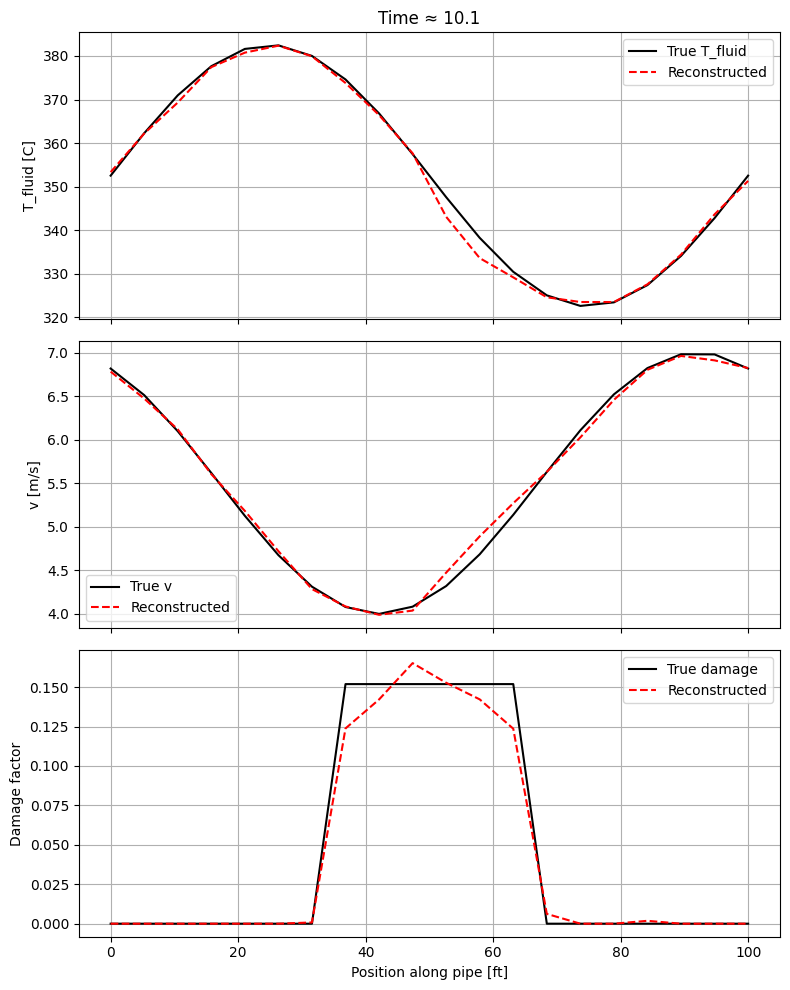

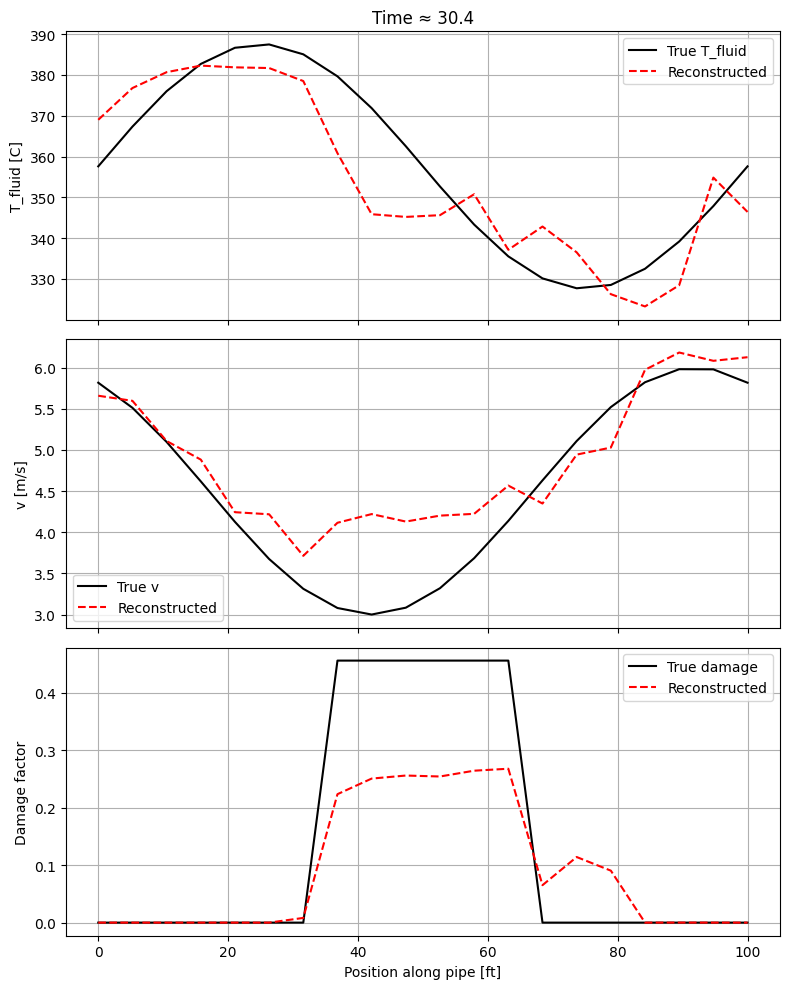

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

np.random.seed(1234)

# -----------------------------
# 1. Space–time grid and "true" fields (same structure as Tier 1.3)
# -----------------------------
n_planes = 20
n_time   = 80

z = np.linspace(0, 100, n_planes)          # position [ft]
t = np.linspace(0, 40, n_time)             # time [arb units]

Z, Tm = np.meshgrid(z, t, indexing='ij')

T_fluid_base = 350 + 30 * np.sin(2 * np.pi * Z / 100)
v_base       = 5 + 1.5 * np.cos(2 * np.pi * Z / 100 + 0.5)
P_base       = 100 + 5 * (1 - Z / 100)

T_fluid_true = T_fluid_base + 10 * (Tm / Tm.max())  # slow global heating
v_true       = v_base + 0.5 * np.sin(2 * np.pi * Tm / Tm.max())
P_true       = P_base - 2 * (Tm / Tm.max())

D_true = np.zeros_like(Z)
damage_region = (Z > 35) & (Z < 65)
D_true[damage_region] = 0.6 * (Tm[damage_region] / Tm.max())

T_wall_true = T_fluid_true + 8 * np.exp(-Z / 60)

# -----------------------------
# 2. More physical σ(T) and μ(T) + skin-depth-based impedance
# -----------------------------
freqs = np.array([500, 2000, 8000])  # Hz
mu0 = 4 * np.pi * 1e-7               # H/m

def sigma_steel(Tw):
    """
    Very rough conductivity model for carbon steel vs temperature.
    Units arbitrary but monotonic: sigma decreases with T.
    """
    # Reference: sigma_ref at 20 C, linear-ish drop with T
    sigma_ref = 6.0e6   # S/m (order of magnitude)
    alpha = 0.004       # per degree C
    return sigma_ref / (1 + alpha * (Tw - 20))

def mu_r_steel(Tw):
    """
    Rough relative permeability vs temperature:
    high at moderate T, decreasing as T rises.
    """
    # Peak around ~200-300 C, then decays
    return 80 * np.exp(-((Tw - 250) / 150)**2) + 1.0

def surface_impedance_components(Tw, D):
    """
    Compute R and X at each frequency using a skin-depth-like model:
    Z_s ~ (1 + j) * sqrt(omega * mu / (2 * sigma))
    Damage increases effective resistivity and perturbs mu.
    """
    sigma = sigma_steel(Tw) * (1.0 - 0.6 * D)  # damage reduces effective sigma
    mu_r  = mu_r_steel(Tw) * (1.0 + 0.5 * D)   # damage perturbs mu
    mu    = mu0 * mu_r

    R_list = []
    X_list = []
    for f in freqs:
        omega = 2 * np.pi * f
        # magnitude of surface impedance
        Z_mag = np.sqrt(omega * mu / (2 * sigma + 1e-12))
        # (1 + j) factor: equal R and X in magnitude, we add some noise
        R = Z_mag * (1 + 0.05 * np.random.randn())
        X = Z_mag * (1 + 0.05 * np.random.randn())
        R_list.append(R)
        X_list.append(X)
    return np.array(R_list), np.array(X_list)

def generate_em_features_tier2(Tw, Tf, v, P, D):
    """
    Tier 2 EM features:
    - Coarse: R, X at 3 frequencies from skin-depth-based model
    - Fine: noise RMS, burstiness, spectral slope, spike rate
    """
    R, X = surface_impedance_components(Tw, D)

    # Fine-grain features: now explicitly tied to T, v, D
    # Noise RMS grows with v, D, Tw, Tf
    noise_rms = (
        0.1
        + 0.03 * (v - 5)
        + 0.06 * D
        + 0.0008 * (Tw - 350)
        + 0.0006 * (Tf - 350)
        + 0.01 * np.random.randn()
    )

    # Burstiness: more with v, D, and high Tf (boiling/turbulence proxy)
    burstiness = (
        0.2
        + 0.07 * (v - 5)
        + 0.15 * D
        + 0.001 * (Tf - 350)
        + 0.01 * np.random.randn()
    )

    # Spectral slope: steeper with more damage and higher Tw
    spectral_slope = (
        -1.5
        + 0.003 * (Tw - 350)
        - 0.6 * D
        + 0.05 * np.random.randn()
    )

    # Spike rate: micro-discharge / transient events
    spike_rate = (
        5
        + 1.0 * D
        + 0.4 * (v - 5)
        + 0.002 * (Tw - 350)
        + 0.0015 * (Tf - 350)
        + np.random.randn()
    )

    features = np.concatenate([R, X, [noise_rms, burstiness, spectral_slope, spike_rate]])
    return features

# Generate features for all planes and times
X_list = []
y_Tf_list = []
y_v_list = []
y_D_list = []
pos_list = []
time_list = []

for i in range(n_planes):
    for j in range(n_time):
        Tw = T_wall_true[i, j]
        Tf = T_fluid_true[i, j]
        v  = v_true[i, j]
        P  = P_true[i, j]
        D  = D_true[i, j]

        feats = generate_em_features_tier2(Tw, Tf, v, P, D)
        X_list.append(feats)
        y_Tf_list.append(Tf)
        y_v_list.append(v)
        y_D_list.append(D)
        pos_list.append(z[i])
        time_list.append(t[j])

X_features = np.array(X_list)
y_Tf = np.array(y_Tf_list)
y_v  = np.array(y_v_list)
y_D  = np.array(y_D_list)
pos  = np.array(pos_list)
time = np.array(time_list)

print("Feature vector length per plane-time (Tier 2):", X_features.shape[1])
print("Total samples:", X_features.shape[0])

# -----------------------------
# 3. Train on early time, test on late time
# -----------------------------
time_threshold = np.median(time)
train_mask = time <= time_threshold
test_mask  = time > time_threshold

def train_and_eval(name, y):
    model = RandomForestRegressor(n_estimators=600, random_state=42)
    model.fit(X_features[train_mask], y[train_mask])
    y_pred = model.predict(X_features[test_mask])
    r2 = r2_score(y[test_mask], y_pred)
    print(f"{name} R^2 (Tier 2, train early, test late): {r2:.3f}")
    y_all = model.predict(X_features)
    return model, y_all

model_Tf, Tf_pred_all = train_and_eval("T_fluid", y_Tf)
model_v,  v_pred_all  = train_and_eval("v",       y_v)
model_D,  D_pred_all  = train_and_eval("damage",  y_D)

# -----------------------------
# 4. Visualize early and late time slices
# -----------------------------
def plot_slice(time_value, Tf_true, Tf_pred, v_true, v_pred, D_true, D_pred):
    idx_t = np.argmin(np.abs(t - time_value))
    z_slice = z

    Tf_t = Tf_true.reshape(n_planes, n_time)[:, idx_t]
    Tf_p = Tf_pred.reshape(n_planes, n_time)[:, idx_t]
    v_t  = v_true.reshape(n_planes, n_time)[:, idx_t]
    v_p  = v_pred.reshape(n_planes, n_time)[:, idx_t]
    D_t  = D_true.reshape(n_planes, n_time)[:, idx_t]
    D_p  = D_pred.reshape(n_planes, n_time)[:, idx_t]

    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    axes[0].plot(z_slice, Tf_t, 'k-', label='True T_fluid')
    axes[0].plot(z_slice, Tf_p, 'r--', label='Reconstructed')
    axes[0].set_ylabel("T_fluid [C]")
    axes[0].set_title(f"Time ≈ {time_value:.1f}")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(z_slice, v_t, 'k-', label='True v')
    axes[1].plot(z_slice, v_p, 'r--', label='Reconstructed')
    axes[1].set_ylabel("v [m/s]")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(z_slice, D_t, 'k-', label='True damage')
    axes[2].plot(z_slice, D_p, 'r--', label='Reconstructed')
    axes[2].set_ylabel("Damage factor")
    axes[2].set_xlabel("Position along pipe [ft]")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

plot_slice(time_value=t[int(n_time*0.25)],
           Tf_true=T_fluid_true, Tf_pred=Tf_pred_all,
           v_true=v_true, v_pred=v_pred_all,
           D_true=D_true, D_pred=D_pred_all)

plot_slice(time_value=t[int(n_time*0.75)],
           Tf_true=T_fluid_true, Tf_pred=Tf_pred_all,
           v_true=v_true, v_pred=v_pred_all,
           D_true=D_true, D_pred=D_pred_all)

Tier 3: realistic physics with known values for steel boiler wall thickness. Stage 1: uncalibrated

Feature vector length per plane-time (Tier 3): 10
Total samples: 1600
T_fluid R^2 (Tier 3, train early, test late): 0.308
v R^2 (Tier 3, train early, test late): 0.205
damage R^2 (Tier 3, train early, test late): 0.584


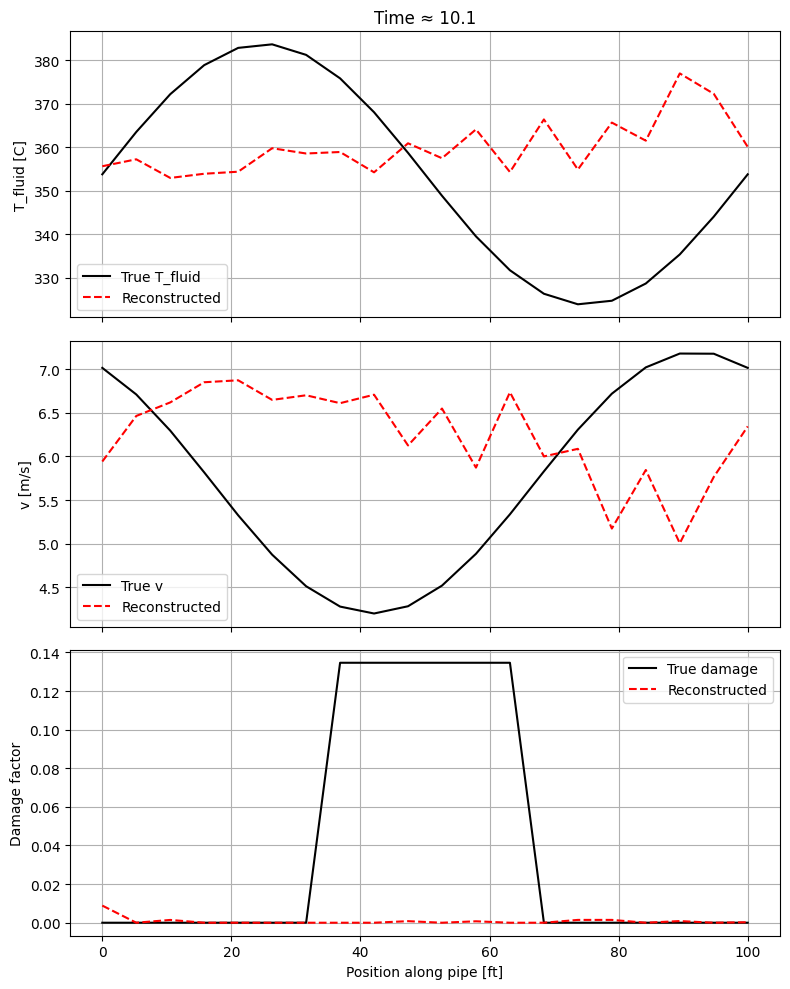

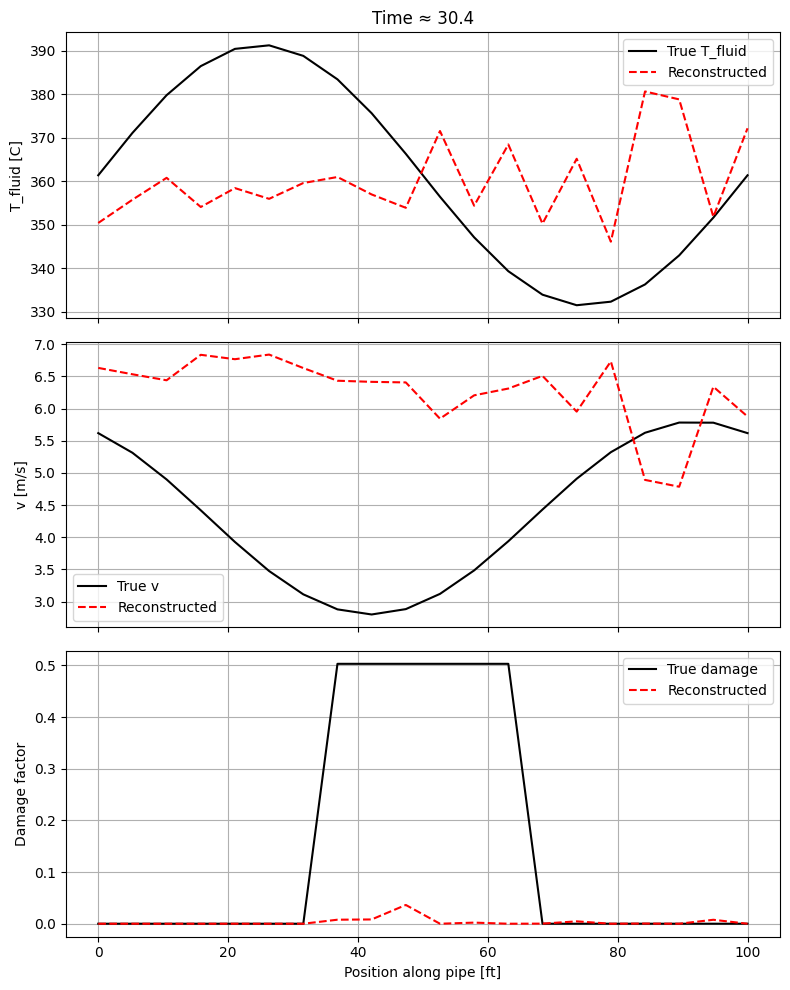

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

np.random.seed(2026)

# -----------------------------
# 1. Space–time grid and "true" fields
# -----------------------------
n_planes = 20
n_time   = 80

z = np.linspace(0, 100, n_planes)          # position [ft]
t = np.linspace(0, 40, n_time)             # time [arb units]

Z, Tm = np.meshgrid(z, t, indexing='ij')

# Base spatial patterns
T_fluid_base = 350 + 30 * np.sin(2 * np.pi * Z / 100)
v_base       = 5 + 1.5 * np.cos(2 * np.pi * Z / 100 + 0.5)
P_base       = 100 + 5 * (1 - Z / 100)

# Time evolution
T_fluid_true = T_fluid_base + 15 * (Tm / Tm.max())  # stronger global heating
v_true       = v_base + 0.7 * np.sin(2 * np.pi * Tm / Tm.max())
P_true       = P_base - 3 * (Tm / Tm.max())

# Damage: grows in mid-section, but not uniformly in time
D_true = np.zeros_like(Z)
damage_region = (Z > 35) & (Z < 65)
D_true[damage_region] = 0.7 * np.clip((Tm[damage_region] / Tm.max())**1.2, 0, 1)

# Wall temperature: slightly above fluid, with some axial decay
T_wall_true = T_fluid_true + 10 * np.exp(-Z / 60)

# -----------------------------
# 2. Radial layering and material models
# -----------------------------
# Layers: [steel_outer, steel_inner, fluid_near_wall, fluid_core]
n_layers = 4

# Rough thickness fractions (normalized)
layer_thickness = np.array([0.25, 0.25, 0.25, 0.25])

mu0 = 4 * np.pi * 1e-7  # H/m

def sigma_steel(T):
    # Rough conductivity vs T for carbon steel (S/m)
    sigma_ref = 6.0e6
    alpha = 0.004
    return sigma_ref / (1 + alpha * (T - 20))

def mu_r_steel(T):
    # Relative permeability vs T: peak at moderate T, decays at high T
    return 80 * np.exp(-((T - 250) / 150)**2) + 1.0

def sigma_fluid(T):
    # Very rough: conductive fluid, conductivity increases with T
    sigma_ref = 1.0e3
    beta = 0.002
    return sigma_ref * (1 + beta * (T - 300))

def mu_r_fluid(T):
    # Assume near non-magnetic
    return 1.0

# Frequencies for driven response
freqs = np.array([500, 2000, 8000])  # Hz

def layered_surface_impedance(Tw, Tf, D, v):
    """
    Approximate layered surface impedance:
    - Two steel layers (outer/inner) with damage affecting inner layer more
    - Two fluid layers (near-wall, core)
    - Combine contributions using a simple series-like mixing
    """
    # Steel layers
    sigma_steel_outer = sigma_steel(Tw) * (1.0 - 0.3 * D)
    sigma_steel_inner = sigma_steel(Tw) * (1.0 - 0.8 * D)  # more affected by damage
    mu_r_outer = mu_r_steel(Tw) * (1.0 + 0.2 * D)
    mu_r_inner = mu_r_steel(Tw) * (1.0 + 0.6 * D)

    # Fluid layers
    sigma_fluid_near = sigma_fluid(Tf) * (1.0 + 0.1 * (v - 5))
    sigma_fluid_core = sigma_fluid(Tf)
    mu_r_fluid_near = mu_r_fluid(Tf)
    mu_r_fluid_core = mu_r_fluid(Tf)

    sigmas = np.array([
        sigma_steel_outer,
        sigma_steel_inner,
        sigma_fluid_near,
        sigma_fluid_core
    ])
    mu_rs = np.array([
        mu_r_outer,
        mu_r_inner,
        mu_r_fluid_near,
        mu_r_fluid_core
    ])

    R_list = []
    X_list = []

    for f in freqs:
        omega = 2 * np.pi * f
        # For each layer, compute a skin-depth-like impedance
        Z_layers = []
        for k in range(n_layers):
            sigma_k = sigmas[k]
            mu_k = mu0 * mu_rs[k]
            # magnitude of surface impedance for layer k
            Z_mag_k = np.sqrt(omega * mu_k / (2 * sigma_k + 1e-18))
            # (1 + j) factor, plus small randomness
            R_k = Z_mag_k * (1 + 0.03 * np.random.randn())
            X_k = Z_mag_k * (1 + 0.03 * np.random.randn())
            # weight by thickness fraction
            Z_layers.append((R_k + 1j * X_k) * layer_thickness[k])

        # Combine layers in series-like fashion
        Z_total = np.sum(Z_layers)
        R_list.append(np.real(Z_total))
        X_list.append(np.imag(Z_total))

    return np.array(R_list), np.array(X_list)

# -----------------------------
# 3. Charge dynamics model (streaming + discharge)
# -----------------------------
def charge_dynamics_features(Tw, Tf, v, D, prev_charge):
    """
    Simple charge model:
    - Generation rate grows with v, D, and Tf
    - Discharge time grows with Tw (hotter steel holds charge longer)
    - prev_charge is the charge level from previous time step
    """
    # Generation rate
    gen_rate = (
        1.0
        + 0.4 * (v - 5)
        + 2.0 * D
        + 0.003 * (Tf - 350)
    )

    # Discharge time constant (longer at higher Tw, more damage)
    tau = 0.5 + 0.002 * (Tw - 350) + 0.5 * D
    tau = max(tau, 0.05)

    # Simple Euler update for charge
    dt = t[1] - t[0]
    charge_new = prev_charge * np.exp(-dt / tau) + gen_rate * dt

    # Features derived from charge
    noise_rms = 0.05 + 0.01 * charge_new + 0.005 * np.random.randn()
    burstiness = 0.2 + 0.02 * charge_new + 0.01 * D + 0.01 * np.random.randn()
    spectral_slope = -1.5 + 0.0005 * charge_new - 0.4 * D + 0.05 * np.random.randn()
    spike_rate = 3 + 0.5 * charge_new + 1.0 * D + 0.5 * (v - 5) + np.random.randn()

    return charge_new, noise_rms, burstiness, spectral_slope, spike_rate

# -----------------------------
# 4. Generate features over space–time with charge memory
# -----------------------------
X_list = []
y_Tf_list = []
y_v_list = []
y_D_list = []
pos_list = []
time_list = []

# Initialize charge memory per plane
charge_prev = np.zeros(n_planes)

for j in range(n_time):
    for i in range(n_planes):
        Tw = T_wall_true[i, j]
        Tf = T_fluid_true[i, j]
        v  = v_true[i, j]
        D  = D_true[i, j]

        # Coarse EM: layered impedance
        R, X = layered_surface_impedance(Tw, Tf, D, v)

        # Fine-grain: charge dynamics
        charge_new, noise_rms, burstiness, spectral_slope, spike_rate = charge_dynamics_features(
            Tw, Tf, v, D, charge_prev[i]
        )
        charge_prev[i] = charge_new

        features = np.concatenate([R, X, [noise_rms, burstiness, spectral_slope, spike_rate]])
        X_list.append(features)
        y_Tf_list.append(Tf)
        y_v_list.append(v)
        y_D_list.append(D)
        pos_list.append(z[i])
        time_list.append(t[j])

X_features = np.array(X_list)
y_Tf = np.array(y_Tf_list)
y_v  = np.array(y_v_list)
y_D  = np.array(y_D_list)
pos  = np.array(pos_list)
time = np.array(time_list)

print("Feature vector length per plane-time (Tier 3):", X_features.shape[1])
print("Total samples:", X_features.shape[0])

# -----------------------------
# 5. Train on early time, test on late time
# -----------------------------
time_threshold = np.median(time)
train_mask = time <= time_threshold
test_mask  = time > time_threshold

def train_and_eval(name, y):
    model = RandomForestRegressor(n_estimators=700, random_state=42, max_depth=None)
    model.fit(X_features[train_mask], y[train_mask])
    y_pred = model.predict(X_features[test_mask])
    r2 = r2_score(y[test_mask], y_pred)
    print(f"{name} R^2 (Tier 3, train early, test late): {r2:.3f}")
    y_all = model.predict(X_features)
    return model, y_all

model_Tf, Tf_pred_all = train_and_eval("T_fluid", y_Tf)
model_v,  v_pred_all  = train_and_eval("v",       y_v)
model_D,  D_pred_all  = train_and_eval("damage",  y_D)

# -----------------------------
# 6. Visualize early and late time slices
# -----------------------------
def plot_slice(time_value, Tf_true, Tf_pred, v_true, v_pred, D_true, D_pred):
    idx_t = np.argmin(np.abs(t - time_value))
    Tf_t = Tf_true.reshape(n_planes, n_time)[:, idx_t]
    Tf_p = Tf_pred.reshape(n_planes, n_time)[:, idx_t]
    v_t  = v_true.reshape(n_planes, n_time)[:, idx_t]
    v_p  = v_pred.reshape(n_planes, n_time)[:, idx_t]
    D_t  = D_true.reshape(n_planes, n_time)[:, idx_t]
    D_p  = D_pred.reshape(n_planes, n_time)[:, idx_t]

    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    axes[0].plot(z, Tf_t, 'k-', label='True T_fluid')
    axes[0].plot(z, Tf_p, 'r--', label='Reconstructed')
    axes[0].set_ylabel("T_fluid [C]")
    axes[0].set_title(f"Time ≈ {time_value:.1f}")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(z, v_t, 'k-', label='True v')
    axes[1].plot(z, v_p, 'r--', label='Reconstructed')
    axes[1].set_ylabel("v [m/s]")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(z, D_t, 'k-', label='True damage')
    axes[2].plot(z, D_p, 'r--', label='Reconstructed')
    axes[2].set_ylabel("Damage factor")
    axes[2].set_xlabel("Position along pipe [ft]")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

plot_slice(time_value=t[int(n_time*0.25)],
           Tf_true=T_fluid_true, Tf_pred=Tf_pred_all,
           v_true=v_true, v_pred=v_pred_all,
           D_true=D_true, D_pred=D_pred_all)

plot_slice(time_value=t[int(n_time*0.75)],
           Tf_true=T_fluid_true, Tf_pred=Tf_pred_all,
           v_true=v_true, v_pred=v_pred_all,
           D_true=D_true, D_pred=D_pred_all)

Stage 2: broadsweep for multiple fluid types, operating temperatures, and EMF power.

In [ ]:
import numpy as np

np.random.seed(7)

# -----------------------------
# 1. Scenario definitions
# -----------------------------
fluids = {
    "water_liquid": {
        "base_sigma": 5e-1,   # S/m (rough)
        "base_mu_r": 1.0,
        "density": 1000,
    },
    "steam": {
        "base_sigma": 1e-4,
        "base_mu_r": 1.0,
        "density": 5,
    },
    "natural_gas": {
        "base_sigma": 1e-6,
        "base_mu_r": 1.0,
        "density": 0.8,
    }
}

stages = {
    "startup_cold": {
        "T_wall": 150,
        "T_fluid": 120,
    },
    "operational": {
        "T_wall": 400,
        "T_fluid": 360,
    },
    "overload": {
        "T_wall": 520,
        "T_fluid": 480,
    }
}

wall_thicknesses = {
    "thin": 0.015,   # m
    "nominal": 0.030,
    "thick": 0.050
}

flow_levels = {
    "low": 2.0,      # m/s
    "medium": 5.0,
    "high": 9.0
}

pressure_levels = {
    "low": 40,       # bar
    "medium": 100,
    "high": 180
}

coil_drive_levels = {
    "off": 0.0,
    "low": 0.3,
    "medium": 1.0,
    "high": 3.0
}

freqs = np.array([500, 2000, 8000])  # Hz
mu0 = 4 * np.pi * 1e-7

# -----------------------------
# 2. Material models
# -----------------------------
def sigma_steel(T):
    sigma_ref = 6.0e6
    alpha = 0.004
    return sigma_ref / (1 + alpha * (T - 20))

def mu_r_steel(T):
    return 80 * np.exp(-((T - 250) / 150)**2) + 1.0

def sigma_fluid_base(fluid_name, T):
    base = fluids[fluid_name]["base_sigma"]
    if fluid_name == "water_liquid":
        return base * (1 + 0.01 * (T - 300) / 100)
    elif fluid_name == "steam":
        return base * (1 + 0.02 * (T - 300) / 100)
    else:  # natural gas
        return base * (1 + 0.03 * (T - 300) / 100)

def mu_r_fluid(fluid_name, T):
    return fluids[fluid_name]["base_mu_r"]

# -----------------------------
# 3. Coarse eddy-current features (with wall thickness & EMF)
# -----------------------------
def coarse_features(fluid_name, stage_name, wall_thick, flow, pressure, coil_drive):
    Tw = stages[stage_name]["T_wall"]
    Tf = stages[stage_name]["T_fluid"]

    sigma_s = sigma_steel(Tw)
    mu_r_s  = mu_r_steel(Tw)
    sigma_f = sigma_fluid_base(fluid_name, Tf)
    mu_r_f  = mu_r_fluid(fluid_name, Tf)

    # Effective parameters: steel wall dominates, fluid perturbs
    # Wall thickness modulates effective path length / impedance
    thickness_factor = wall_thick / 0.03  # nominal thickness normalization

    R_list = []
    X_list = []

    for f in freqs:
        omega = 2 * np.pi * f

        # Steel surface impedance (skin-depth-like)
        Zs_mag = np.sqrt(omega * mu0 * mu_r_s / (2 * sigma_s + 1e-18))

        # Fluid perturbation: more conductive fluid + higher flow/pressure → more perturbation
        fluid_factor = (sigma_f / (sigma_f + sigma_s)) * (1 + 0.1 * (flow - 5) + 0.05 * (pressure - 100) / 100)

        # Coil drive: higher drive → stronger signal, but also more nonlinearity
        drive_factor = 1 + 0.5 * coil_drive

        # Combine
        Z_mag_eff = Zs_mag * thickness_factor * drive_factor * (1 + 0.3 * fluid_factor)

        # Split into R/X with some randomness
        R = Z_mag_eff * (1 + 0.05 * np.random.randn())
        X = Z_mag_eff * (1 + 0.05 * np.random.randn())

        R_list.append(R)
        X_list.append(X)

    return np.array(R_list), np.array(X_list)

# -----------------------------
# 4. Fine-grain static/charge features
# -----------------------------
def fine_features(fluid_name, stage_name, wall_thick, flow, pressure, coil_drive):
    Tw = stages[stage_name]["T_wall"]
    Tf = stages[stage_name]["T_fluid"]

    # Streaming/triboelectric generation: more with flow, pressure, and density
    density = fluids[fluid_name]["density"]
    gen_rate = (
        1.0
        + 0.4 * (flow - 5)
        + 0.3 * (pressure - 100) / 100
        + 0.002 * (Tf - 350)
        + 0.001 * (Tw - 350)
        + 0.2 * np.log1p(density)
    )

    # Discharge time: longer at higher Tw and thicker wall
    tau = 0.3 + 0.002 * (Tw - 350) + 0.5 * (wall_thick - 0.03) / 0.03
    tau = max(tau, 0.05)

    # Coil drive: with drive off, we only see passive induction; with drive on, we amplify
    drive_gain = 0.5 + coil_drive

    # Effective "charge level" proxy
    charge_level = gen_rate * tau * drive_gain

    # Features
    noise_rms = 0.05 + 0.01 * charge_level + 0.005 * np.random.randn()
    burstiness = 0.2 + 0.02 * charge_level + 0.01 * np.random.randn()
    spectral_slope = -1.5 + 0.0005 * charge_level + 0.05 * np.random.randn()
    spike_rate = 3 + 0.4 * charge_level + 0.5 * (flow - 5) + np.random.randn()

    return noise_rms, burstiness, spectral_slope, spike_rate

# -----------------------------
# 5. Sweep all combinations and print summaries
# -----------------------------
def summarize_features(R, X, noise_rms, burstiness, spectral_slope, spike_rate):
    # Simple scalar summaries for printing
    return {
        "R_mean": float(np.mean(R)),
        "X_mean": float(np.mean(X)),
        "R_span": float(np.max(R) - np.min(R)),
        "X_span": float(np.max(X) - np.min(X)),
        "noise_rms": float(noise_rms),
        "burstiness": float(burstiness),
        "spectral_slope": float(spectral_slope),
        "spike_rate": float(spike_rate),
    }

results = []

for fluid_name in fluids.keys():
    print("\n==============================")
    print(f"FLUID: {fluid_name}")
    print("==============================")
    for stage_name in stages.keys():
        print(f"\n  Stage: {stage_name}")
        for wall_name, wall_thick in wall_thicknesses.items():
            for flow_name, flow in flow_levels.items():
                for P_name, P in pressure_levels.items():
                    for drive_name, drive in coil_drive_levels.items():
                        R, X = coarse_features(fluid_name, stage_name, wall_thick, flow, P, drive)
                        noise_rms, burstiness, spectral_slope, spike_rate = fine_features(
                            fluid_name, stage_name, wall_thick, flow, P, drive
                        )
                        summary = summarize_features(R, X, noise_rms, burstiness, spectral_slope, spike_rate)
                        results.append({
                            "fluid": fluid_name,
                            "stage": stage_name,
                            "wall": wall_name,
                            "flow": flow_name,
                            "pressure": P_name,
                            "drive": drive_name,
                            **summary
                        })
                        # Print a compact line for this combo
                        print(
                            f"    wall={wall_name:7s}, flow={flow_name:6s}, P={P_name:6s}, drive={drive_name:6s} | "
                            f"R_mean={summary['R_mean']:.3e}, X_mean={summary['X_mean']:.3e}, "
                            f"noise={summary['noise_rms']:.3f}, spikes={summary['spike_rate']:.2f}"
                        )

print("\nTotal scenarios simulated:", len(results))


FLUID: water_liquid

  Stage: startup_cold
    wall=thin   , flow=low   , P=low   , drive=off    | R_mean=1.868e-04, X_mean=1.891e-04, noise=0.050, spikes=2.10
    wall=thin   , flow=low   , P=low   , drive=low    | R_mean=2.161e-04, X_mean=2.069e-04, noise=0.053, spikes=-0.02
    wall=thin   , flow=low   , P=low   , drive=medium | R_mean=2.844e-04, X_mean=2.798e-04, noise=0.048, spikes=1.09
    wall=thin   , flow=low   , P=low   , drive=high   | R_mean=4.302e-04, X_mean=4.700e-04, noise=0.045, spikes=1.19
    wall=thin   , flow=low   , P=medium, drive=off    | R_mean=1.821e-04, X_mean=1.767e-04, noise=0.052, spikes=0.98
    wall=thin   , flow=low   , P=medium, drive=low    | R_mean=2.194e-04, X_mean=2.162e-04, noise=0.043, spikes=2.70
    wall=thin   , flow=low   , P=medium, drive=medium | R_mean=2.787e-04, X_mean=2.788e-04, noise=0.044, spikes=0.34
    wall=thin   , flow=low   , P=medium, drive=high   | R_mean=4.977e-04, X_mean=4.775e-04, noise=0.053, spikes=-0.24
    wall=thin   , 

Stage 3: Same simulation with read friendly output, visuals, calibration to track reconstructed data.

Total scenarios: 972

=== Calibration summary (feature shift by stage) ===

Fluid: water_liquid
  R_mean:
    startup_cold : 6.108e-04
    operational  : 6.034e-04
    overload     : 2.421e-04
  spike_rate:
    startup_cold : 3.296e+00
    operational  : 3.903e+00
    overload     : 4.383e+00
  noise_rms:
    startup_cold : 5.358e-02
    operational  : 6.729e-02
    overload     : 8.115e-02

Fluid: steam
  R_mean:
    startup_cold : 6.090e-04
    operational  : 6.048e-04
    overload     : 2.412e-04
  spike_rate:
    startup_cold : 3.292e+00
    operational  : 3.638e+00
    overload     : 3.881e+00
  noise_rms:
    startup_cold : 5.113e-02
    operational  : 6.066e-02
    overload     : 7.021e-02

Fluid: natural_gas
  R_mean:
    startup_cold : 6.083e-04
    operational  : 5.996e-04
    overload     : 2.424e-04
  spike_rate:
    startup_cold : 3.053e+00
    operational  : 3.671e+00
    overload     : 4.005e+00
  noise_rms:
    startup_cold : 5.088e-02
    operational  : 5.961e-02
    o

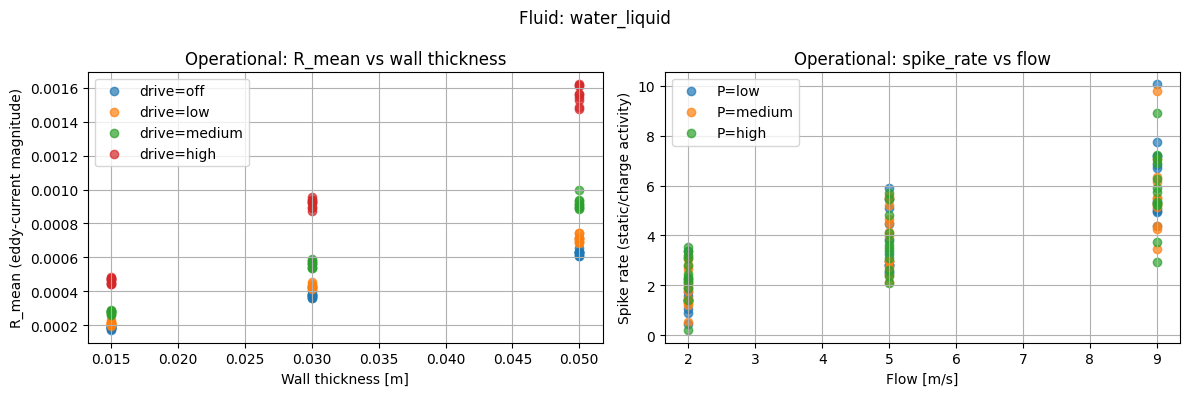

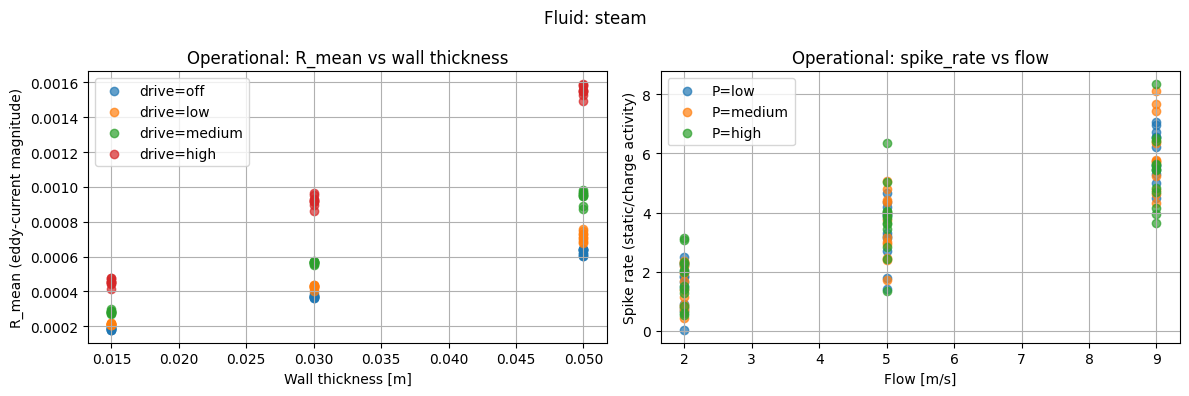

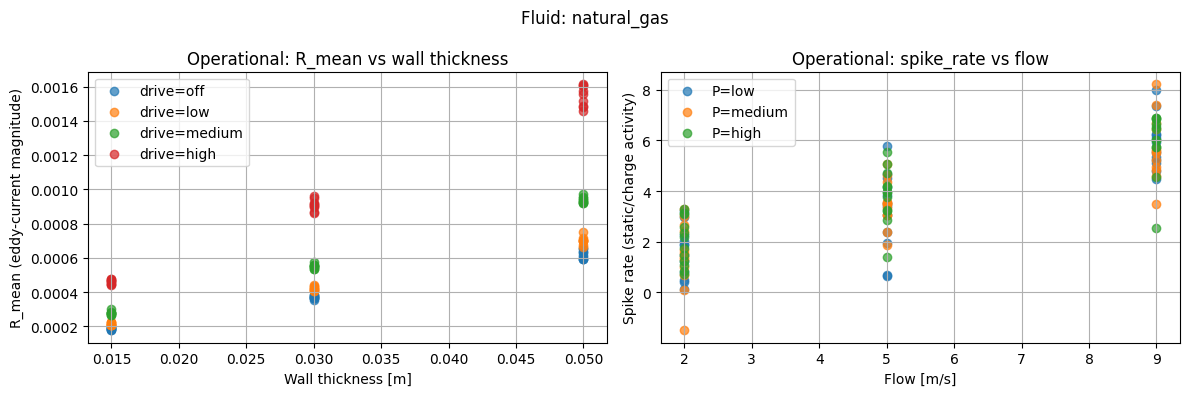

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

np.random.seed(11)

# -----------------------------
# 1. Scenario definitions
# -----------------------------
fluids = {
    "water_liquid": {"base_sigma": 5e-1, "base_mu_r": 1.0, "density": 1000},
    "steam":        {"base_sigma": 1e-4, "base_mu_r": 1.0, "density": 5},
    "natural_gas":  {"base_sigma": 1e-6, "base_mu_r": 1.0, "density": 0.8},
}

stages = {
    "startup_cold": {"T_wall": 150, "T_fluid": 120},
    "operational":  {"T_wall": 400, "T_fluid": 360},
    "overload":     {"T_wall": 520, "T_fluid": 480},
}

wall_thicknesses = {"thin": 0.015, "nominal": 0.030, "thick": 0.050}
flow_levels      = {"low": 2.0, "medium": 5.0, "high": 9.0}
pressure_levels  = {"low": 40, "medium": 100, "high": 180}
coil_drive_levels = {"off": 0.0, "low": 0.3, "medium": 1.0, "high": 3.0}

freqs = np.array([500, 2000, 8000])  # Hz
mu0 = 4 * np.pi * 1e-7

# -----------------------------
# 2. Material models
# -----------------------------
def sigma_steel(T):
    sigma_ref = 6.0e6
    alpha = 0.004
    return sigma_ref / (1 + alpha * (T - 20))

def mu_r_steel(T):
    return 80 * np.exp(-((T - 250) / 150)**2) + 1.0

def sigma_fluid_base(fluid_name, T):
    base = fluids[fluid_name]["base_sigma"]
    if fluid_name == "water_liquid":
        return base * (1 + 0.01 * (T - 300) / 100)
    elif fluid_name == "steam":
        return base * (1 + 0.02 * (T - 300) / 100)
    else:
        return base * (1 + 0.03 * (T - 300) / 100)

def mu_r_fluid(fluid_name, T):
    return fluids[fluid_name]["base_mu_r"]

# -----------------------------
# 3. Coarse eddy-current features
# -----------------------------
def coarse_features(fluid_name, stage_name, wall_thick, flow, pressure, coil_drive):
    Tw = stages[stage_name]["T_wall"]
    Tf = stages[stage_name]["T_fluid"]

    sigma_s = sigma_steel(Tw)
    mu_r_s  = mu_r_steel(Tw)
    sigma_f = sigma_fluid_base(fluid_name, Tf)
    mu_r_f  = mu_r_fluid(fluid_name, Tf)

    thickness_factor = wall_thick / 0.03

    R_list, X_list = [], []
    for f in freqs:
        omega = 2 * np.pi * f
        Zs_mag = np.sqrt(omega * mu0 * mu_r_s / (2 * sigma_s + 1e-18))

        fluid_factor = (sigma_f / (sigma_f + sigma_s)) * (
            1 + 0.1 * (flow - 5) + 0.05 * (pressure - 100) / 100
        )
        drive_factor = 1 + 0.5 * coil_drive

        Z_mag_eff = Zs_mag * thickness_factor * drive_factor * (1 + 0.3 * fluid_factor)

        R = Z_mag_eff * (1 + 0.05 * np.random.randn())
        X = Z_mag_eff * (1 + 0.05 * np.random.randn())
        R_list.append(R)
        X_list.append(X)

    return np.array(R_list), np.array(X_list)

# -----------------------------
# 4. Fine-grain static/charge features
# -----------------------------
def fine_features(fluid_name, stage_name, wall_thick, flow, pressure, coil_drive):
    Tw = stages[stage_name]["T_wall"]
    Tf = stages[stage_name]["T_fluid"]
    density = fluids[fluid_name]["density"]

    gen_rate = (
        1.0
        + 0.4 * (flow - 5)
        + 0.3 * (pressure - 100) / 100
        + 0.002 * (Tf - 350)
        + 0.001 * (Tw - 350)
        + 0.2 * np.log1p(density)
    )

    tau = 0.3 + 0.002 * (Tw - 350) + 0.5 * (wall_thick - 0.03) / 0.03
    tau = max(tau, 0.05)

    drive_gain = 0.5 + coil_drive
    charge_level = gen_rate * tau * drive_gain

    noise_rms = 0.05 + 0.01 * charge_level + 0.005 * np.random.randn()
    burstiness = 0.2 + 0.02 * charge_level + 0.01 * np.random.randn()
    spectral_slope = -1.5 + 0.0005 * charge_level + 0.05 * np.random.randn()
    spike_rate = 3 + 0.4 * charge_level + 0.5 * (flow - 5) + np.random.randn()

    return noise_rms, burstiness, spectral_slope, spike_rate

# -----------------------------
# 5. Sweep all combinations
# -----------------------------
rows = []
for fluid_name in fluids:
    for stage_name in stages:
        for wall_name, wall_thick in wall_thicknesses.items():
            for flow_name, flow in flow_levels.items():
                for P_name, P in pressure_levels.items():
                    for drive_name, drive in coil_drive_levels.items():
                        R, X = coarse_features(fluid_name, stage_name, wall_thick, flow, P, drive)
                        noise_rms, burstiness, spectral_slope, spike_rate = fine_features(
                            fluid_name, stage_name, wall_thick, flow, P, drive
                        )
                        rows.append({
                            "fluid": fluid_name,
                            "stage": stage_name,
                            "wall": wall_name,
                            "wall_thick": wall_thick,
                            "flow_label": flow_name,
                            "flow": flow,
                            "pressure_label": P_name,
                            "pressure": P,
                            "drive_label": drive_name,
                            "drive": drive,
                            "R_mean": np.mean(R),
                            "X_mean": np.mean(X),
                            "noise_rms": noise_rms,
                            "burstiness": burstiness,
                            "spectral_slope": spectral_slope,
                            "spike_rate": spike_rate,
                        })

df = pd.DataFrame(rows)
print("Total scenarios:", len(df))

# -----------------------------
# 6. Simple "calibration": how features shift from startup -> operational -> overload
# -----------------------------
print("\n=== Calibration summary (feature shift by stage) ===")
for fluid_name in fluids:
    print(f"\nFluid: {fluid_name}")
    for feature in ["R_mean", "spike_rate", "noise_rms"]:
        means_by_stage = df[df["fluid"] == fluid_name].groupby("stage")[feature].mean()
        print(f"  {feature}:")
        for stage_name in ["startup_cold", "operational", "overload"]:
            print(f"    {stage_name:13s}: {means_by_stage[stage_name]:.3e}")

# -----------------------------
# 7. Reader-friendly prints: a few representative scenarios
# -----------------------------
def print_examples(fluid_name, stage_name):
    print(f"\n=== Examples for {fluid_name}, stage={stage_name} ===")
    subset = df[
        (df["fluid"] == fluid_name) &
        (df["stage"] == stage_name)
    ]
    # pick a few combinations
    examples = [
        ("thin", "low", "low", "off"),
        ("nominal", "medium", "medium", "medium"),
        ("thick", "high", "high", "high"),
    ]
    for wall, flow_label, P_label, drive_label in examples:
        row = subset[
            (subset["wall"] == wall) &
            (subset["flow_label"] == flow_label) &
            (subset["pressure_label"] == P_label) &
            (subset["drive_label"] == drive_label)
        ].iloc[0]
        print(
            f"  wall={wall:7s}, flow={flow_label:6s}, P={P_label:6s}, drive={drive_label:6s} | "
            f"R_mean={row['R_mean']:.3e}, spike_rate={row['spike_rate']:.2f}, noise={row['noise_rms']:.3f}"
        )

for fluid_name in fluids:
    for stage_name in ["startup_cold", "operational", "overload"]:
        print_examples(fluid_name, stage_name)

# -----------------------------
# 8. Visual plots per fluid
# -----------------------------
for fluid_name in fluids:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Fluid: {fluid_name}")

    # Left: R_mean vs wall_thick, colored by drive, for operational stage
    sub = df[(df["fluid"] == fluid_name) & (df["stage"] == "operational")]
    for drive_label in coil_drive_levels.keys():
        s = sub[sub["drive_label"] == drive_label]
        axes[0].scatter(s["wall_thick"], s["R_mean"], label=f"drive={drive_label}", alpha=0.7)
    axes[0].set_xlabel("Wall thickness [m]")
    axes[0].set_ylabel("R_mean (eddy-current magnitude)")
    axes[0].set_title("Operational: R_mean vs wall thickness")
    axes[0].legend()
    axes[0].grid(True)

    # Right: spike_rate vs flow, colored by pressure, for operational stage
    for P_label in pressure_levels.keys():
        s = sub[sub["pressure_label"] == P_label]
        axes[1].scatter(s["flow"], s["spike_rate"], label=f"P={P_label}", alpha=0.7)
    axes[1].set_xlabel("Flow [m/s]")
    axes[1].set_ylabel("Spike rate (static/charge activity)")
    axes[1].set_title("Operational: spike_rate vs flow")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()